# Analysis of TED Talk Ratings #

Lawrence Pang and Nicholas Vadivelu

## Introduction ##

In this analysis we try to quantify the impact of various factors on the rating of a TED talk.

First we can load the data: 

In [1]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
import ast

# Load in Python libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plot
from textblob import TextBlob
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD
import scipy.stats
from scipy.stats import gaussian_kde
import re
import ast
import random
from sklearn import preprocessing

matplotlib.style.use('ggplot')

df = pd.read_csv('../input/ted_main.csv')

%matplotlib inline

Using TensorFlow backend.


# Data #
First, let's take a look at the data.

In [2]:
df.sample()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
1892,65,Aziz Abu Sarah is a Palestinian activist with ...,277,TED2014,1395187200,39,Aziz Abu Sarah,"Aziz Abu Sarah: For more tolerance, we need mo...",1,1420646382,"[{'id': 1, 'name': 'Beautiful', 'count': 233},...","[{'id': 1537, 'hero': 'https://pe.tedcdn.com/i...",Entrepreneur + educator,"['Middle East', 'TED Fellows', 'activism', 'cu...","For more tolerance, we need more ... tourism?",https://www.ted.com/talks/aziz_abu_sarah_for_m...,1301734


There are plenty of quantitative features to analyze, including the comments, duration, languages, and more. The description and title can be assessed on their sentiment. We can analyze speakers, tags, and event location using a one-hot encoding.
The name category merely combines information from main_speaker and title. Also, the URL is not useful for our purposes. We will not use either.

## Measuring Ratings ##

To perform this analysis, we need a quantitative definition of a talk's rating. In the data set, such a factor exists, but it is split into various qualitative descriptions. Therefore, we define a measure of aggregate ratings as the sum of some descriptions and the difference of some others. These are considered positive:

* Funny
* Courageous
* Beautiful
* Informative
* Inspiring
* Fascinating
* Ingenious
* Persuasive
* Jaw-dropping

These are considered negative:

* Confusing
* Unconvincing
* Longwinded
* Obnoxious
* OK

There are a couple of factors to note. First, there are significantly more positive than negative descriptors. This would have surely created a bias towards positive ratings. Second, rating system allows each viewer to choose up to three of these descriptors per video. If they choose only one, their rating will be counted three times. This is interesting: the number of descriptors one would choose to describe a video does not necessarily correlate with the strength of their opinion.
Let us graph the frequency of each qualitative rating, with the positive descriptors in red and negative ones in blue.

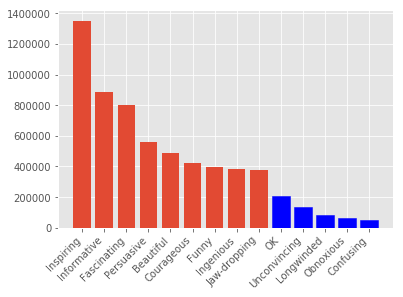

In [3]:

df['ratings'] = df['ratings'].apply(lambda x: eval(str(x))) #turns stringified dictionary into python dictionary

counter = {'Funny':0, 'Beautiful':0, 'Ingenious':0, 'Courageous':0, 'Longwinded':0, 'Confusing':0, 'Informative':0, 'Fascinating':0, 'Unconvincing':0, 'Persuasive':0, 'Jaw-dropping':0, 'OK':0, 'Obnoxious':0, 'Inspiring':0}

for i in range(len(df['ratings'])):
    for j in range(len(df['ratings'][i])):
        counter[df['ratings'][i][j]['name']] += df['ratings'][i][j]['count']
    
frequencies = list(counter.values())
descr = counter.keys()
descriptors = [x for _,x in sorted(zip(frequencies,counter.keys()), reverse=True)]
neg_descriptors = {"Confusing", "Unconvincing", "Longwinded", "Obnoxious", "OK"}
neg_indices  = [x for x in range (len(descriptors)) if descriptors[x] in neg_descriptors]
frequencies.sort(reverse=True)

indices = np.arange(len(descriptors))
bar = plot.bar(indices, frequencies, 0.8)
[bar[i].set_color('b') for i in neg_indices]
plot.xticks(indices, descriptors, rotation=45, ha="right")
plot.show()

Our hypothesis was correct: there is a significant bias towards positive ratings. In addition to the rating options available, we may attribute this to the quality of the TED Talks, or the tendency of the average TED viewer to leave positive feedback over negative feedback. Regardless, we must consider this when analyzing the results.

Below we will create the aggregateRatings feature as described above.

In [12]:
df['aggregateRatings'] = df['ratings'].apply(lambda x: \
                                            x[0]['count']+ \
                                            x[1]['count']- \
                                            x[2]['count']+ \
                                            x[3]['count']- \
                                            x[4]['count']- \
                                            x[5]['count']+ \
                                            x[6]['count']+ \
                                            x[7]['count']+ \
                                            x[8]['count']+ \
                                            x[9]['count']+ \
                                            x[10]['count']+ \
                                            x[11]['count']- \
                                            x[12]['count']- \
                                            x[13]['count'])
                                            

ar = df['aggregateRatings']

## Preliminary Analysis ##

Let us examine the relationship between this aggregate rating measure and some factors present in the data set.

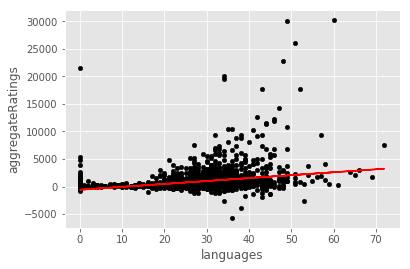

In [13]:
df.plot.scatter(x='languages',y='aggregateRatings',color='black')
#define convenience function for trend lines
def plotTrendLine(x,y,data=df,color='red',logx=False,logy=False):
    oldx = np.reshape(data[x].values,(-1,))
    oldy = np.reshape(data[y].values,(-1,))
    tempx = oldx if not logx else np.log10(oldx)
    tempy = oldy if not logy else np.log10(oldy)
    
    idx = np.isfinite(tempx) & np.isfinite(tempy)
    z = np.polyfit(tempx[idx],tempy[idx],1)
    tempy = z[0]*tempx+z[1]
    plot.plot(oldx,tempy,color=color)
    return z
plotTrendLine('languages','aggregateRatings');

We see that there is a slight correlation between languages and ratings - which doesn't seem immediately intuitive. Possibly this is really attributable to views and comments. 

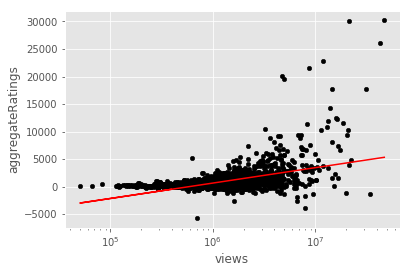

In [14]:
df.plot.scatter(x='views',y='aggregateRatings',color='black')
plotTrendLine('views','aggregateRatings',logx=True);
plot.xscale('log')

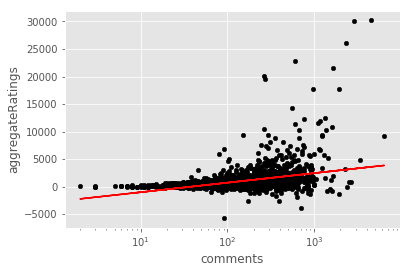

In [15]:
df.plot.scatter(x='comments',y='aggregateRatings',color='black')
plotTrendLine('comments','aggregateRatings',logx=True);
plot.xscale('log')

Again, there is a general positive trend in both cases, with some outliers tending towards more negative ratings. We can conlude rather naturally that talks people like seem to be more viewed and commented on, and thus rated more highly. However, this also introduces a rating bias toward more highly-viewed talks. Thus, we define a new data column which is average aggregate rating:

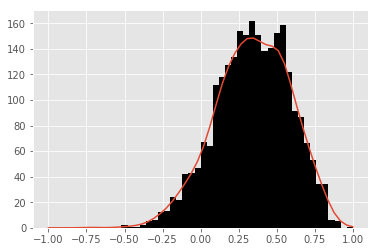

In [16]:
df['totalRatings'] = df['ratings'].apply(lambda x: sum([x[i]['count'] for i in range(len(x))]))

df['avgPerRating'] = df['aggregateRatings']/df['totalRatings']
plot.hist(x=df['avgPerRating'],bins=50,range=(-1,1),color='black')
#convenience function for density curve plotting
def plotDensityCurve(x,linspace,covariance_factor=0.25,multiplier=1,data=df,color='red'):
    tempx = np.reshape(data[x].values,(-1,)) if data is not None else x
    density = gaussian_kde(tempx)
    xs = np.linspace(linspace[0],linspace[1],linspace[2])
    density.covariance_factor = lambda: covariance_factor
    density._compute_covariance()
    plot.plot(xs,density(xs)*multiplier)
plotDensityCurve('avgPerRating',(-1,1,50),multiplier=100)

A histogram of per-view ratings. Note that most talks fall on the positive side - most ratings given are positive. 

Slope: 0.0074883099868


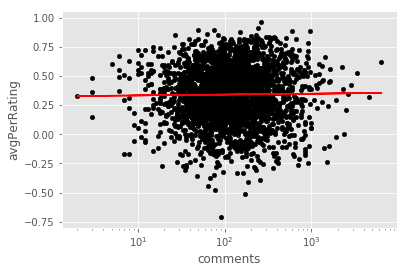

In [17]:
df.plot.scatter(x='comments',y='avgPerRating',color='black')
coeffs = plotTrendLine('comments','avgPerRating',logx=True);
plot.xscale('log')
print("Slope: "+str(coeffs[0]))

Slope: 0.0182969786616


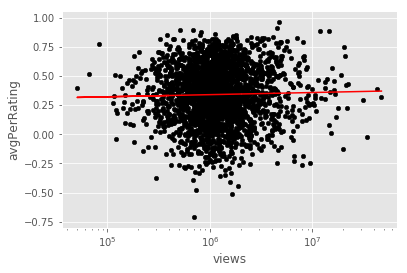

In [18]:
df.plot.scatter(x='views',y='avgPerRating',color='black')
coeffs = plotTrendLine('views','avgPerRating',logx=True);
plot.xscale('log')
print("Slope: "+str(coeffs[0]))

This is more interesting. While more comments seem to indicate higher ratings per view, the opposite is true for number of views.

# Related Video Analysis #

This dataset also provides a list of related for each video. Let us find groups of videos which are connected.

Number of groups: 344
Largest Group Size: 7
Smallest Group Size: 2
Average Group Size: 6.71802325581


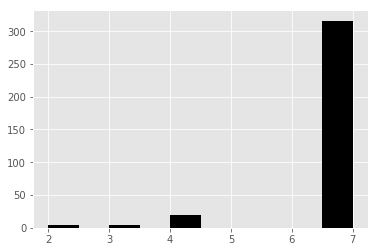

In [19]:
df['related_talks'] = df['related_talks'].apply(lambda x: eval(str(x)))

groups = {}
for i in range(len(df)):
    cur = df['title'][i]
    related = [df['related_talks'][i][j]['title'] for j in range(len(df['related_talks'][i]))]
    groups[cur] = set(related)
    groups[cur].add(cur)
    for rel in related:
        if rel in groups and rel != cur:
            groups[cur].union(groups.pop(rel))
                   
groups = [g for g in groups.values() if len(g) > 0]
lens = [len(t) for t in groups]

plot.hist(lens,color='black')
print("Number of groups: " + str(len(groups)))
print("Largest Group Size: " + str(max(lens)))
print("Smallest Group Size: " + str(min(lens)))
print("Average Group Size: " + str(np.mean(lens)))

Suprisingly, most groups are of size 7. This implies that groups of videos form related groups, whereby each video recommends every other video in the group. These videos are likely grouped in this way through tags, but let us see if there is any relationship between the aggregate rating of the video and the group it is in. We will do this by comparing the standard deviation of the average aggregate scores in each group with the standard deviation of the entire set.

Standard deviation for the set: 0.24348928007078519
Average standard deviation among groups: 0.214335314769


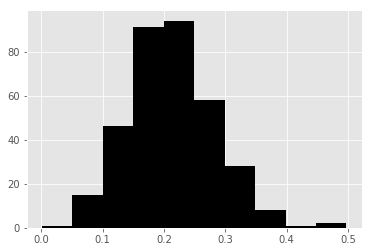

In [20]:
title_to_id = {}
for i in range(len(df)):
    title_to_id[df['title'][i]] = i

group_avg = []
for g in groups:
    group_avg.append([df['avgPerRating'][title_to_id[title]] for title in g])

group_std = [np.std(nums) for nums in group_avg]
plot.hist(group_std,color='black')
print("Standard deviation for the set: " + str(np.std(df['avgPerRating'])))
print("Average standard deviation among groups: " + str(np.mean(group_std)))

From above, the standard deviations in the average aggregate scores within the groups is very similar to the standard deviation of the average aggregate scores for the set overall. This means that these groups range in user satisfaction almost as much the videos overall, implying that the relatedness of two videos is not a strong indicator of their quality.

## Machine Learning ##

What about trying to predict ratings per view based on various factors? This is where machine learning comes in. Let us revisit the data.

In [21]:
df.sample()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,aggregateRatings,totalRatings,avgPerRating
2315,146,The smartphone you use reflects more than just...,464,TEDSummit,1467158400,30,Christopher Soghoian,Christopher Soghoian: Your smartphone is a civ...,1,1477926404,"[{'id': 21, 'name': 'Unconvincing', 'count': 3...","[{'id': 2314, 'hero': 'https://pe.tedcdn.com/i...",Privacy researcher and activist,"['Internet', 'Surveillance', 'TED Fellows', 'a...",Your smartphone is a civil rights issue,https://www.ted.com/talks/christopher_soghoian...,1307805,1217,1775,0.685634


From the sample, there are 7 numeric features that we can use:

In [26]:
mldf = df[['num_speaker','duration','comments','languages','views', 'film_date', 'published_date']]

Currently, this just consists of numerical values which already exist in the TED talks data set. However, it leaves out a lot of factors, such as the title and description of the talk. We can analyze these with natural language processing. 

There are a few approaches that can be taken. One of the possibilities is to perform a sentiment analysis on the description (or possibly the title) and consider this a feature. We can do this with the TextBlob library:

In [27]:
mldf['descriptionSentiment'] = df['description'].apply(lambda x:TextBlob(re.sub(r'[^\x00-\x7f]',r'',x)).sentiment.polarity)
print("Sentiment: ")
print(mldf['descriptionSentiment'].head())
print("Description: ")
print(df['description'].head())

Sentiment: 
0    0.291667
1   -0.115909
2   -0.081981
3    0.000000
4    0.000000
Name: descriptionSentiment, dtype: float64
Description: 
0    Sir Ken Robinson makes an entertaining and pro...
1    With the same humor and humanity he exuded in ...
2    New York Times columnist David Pogue takes aim...
3    In an emotionally charged talk, MacArthur-winn...
4    You've never seen data presented like this. Wi...
Name: description, dtype: object


We can also analyze tags and the event location. We can create a one-hot encoding:

In [28]:
df['tags'] = df['tags'].apply(lambda x:eval(str(x)))
all_tags = {}
count = 0
for talk in df['tags']:
    for tag in talk:
        if not tag in all_tags:
            all_tags[tag] = count
            count = count+1
onehot = np.zeros((0,count))
for talk in df['tags']:
    temp = np.zeros((1,count))
    for tag in talk:
        temp[0,all_tags[tag]] = 1
    onehot = np.concatenate((onehot,temp),0)

Now we are ready to create the machine learning model. Our model will be a neural network, implemented in Keras using a TensorFlow backend. We first create the training and validation data sets, then we create the model.

In [30]:
mldf_np = mldf.as_matrix()
all_y = np.reshape(df['avgPerRating'].as_matrix(),(-1,1))
all_x = np.concatenate((mldf_np,onehot),1)
combined = np.concatenate((all_x,all_y),1)
np.random.shuffle(combined)
data_size = np.shape(all_y)[0]
train_size = (int)(data_size*0.75)
feature_size = np.shape(all_x)[1]
x_train = combined[0:train_size,0:feature_size]
y_train = np.reshape(combined[0:train_size,feature_size],(-1,1))
x_val = combined[train_size:data_size,0:feature_size]
y_val = np.reshape(combined[train_size:data_size,feature_size],(-1,1))

In [77]:
import keras.optimizers as op
from keras.layers import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(feature_size,)))
model.add(Dense(1,kernel_regularizer=l2(0.01)))
model.compile(loss='mean_squared_error',optimizer="adam")
history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=50,validation_data=(x_val,y_val))

Train on 1912 samples, validate on 638 samples
Epoch 1/50
1912/1912 [==============================] - 1s 476us/step - loss: 0.8538 - val_loss: 1.2715
Epoch 2/50
1912/1912 [==============================] - 0s 47us/step - loss: 0.5556 - val_loss: 0.9561
Epoch 3/50
1912/1912 [==============================] - 0s 43us/step - loss: 0.3989 - val_loss: 0.7510
Epoch 4/50
1912/1912 [==============================] - 0s 44us/step - loss: 0.2959 - val_loss: 0.5962
Epoch 5/50
1912/1912 [==============================] - 0s 46us/step - loss: 0.2302 - val_loss: 0.4833
Epoch 6/50
1912/1912 [==============================] - 0s 42us/step - loss: 0.1797 - val_loss: 0.4019
Epoch 7/50
1912/1912 [==============================] - 0s 46us/step - loss: 0.1458 - val_loss: 0.3355
Epoch 8/50
1912/1912 [==============================] - 0s 44us/step - loss: 0.1252 - val_loss: 0.2863
Epoch 9/50
1912/1912 [==============================] - 0s 44us/step - loss: 0.1037 - val_loss: 0.2478
Epoch 10/50
1912/1912 [==

We can graph the loss for this network as well.

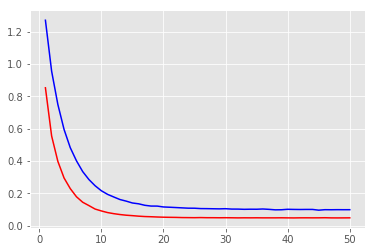

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1,len(loss)+1)
plot.plot(epochs,loss,color='red')
plot.plot(epochs,val_loss,color='blue')

This neural network has the benefit of being easier to understand. As this neural network has linear activation with no hidden layers, its weights can be interpreted as directly affecting the final rating per view. A positive weight would indicate some correlation between that feature and rating per view, and vice versa.

## Factor Analysis ##

We first split the weights into two categories. existing_weights consists of the existing numerical features in the data set, as well as the sentiment of the description. tag_weights, a larger set of features, consists of the weights of each TED talk tag. 

In [79]:
all_weights_temp = model.layers[1].get_weights()[0]
all_weights = []
for weight in all_weights_temp:
    all_weights.append(weight[0])
existing_weights = all_weights[:6]
tag_weights = all_weights[6:]

Let's first examine the relationship between rating per view and the existing numerical features in the data set.

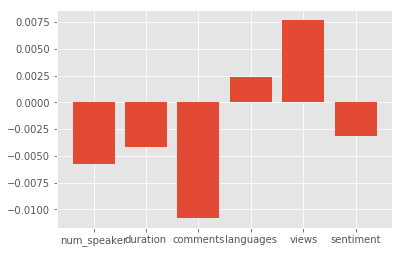

In [80]:
fig,ax = plot.subplots()
index = np.arange(0,6)
ax.bar(index,existing_weights)
ax.set_xticklabels(('','num_speaker','duration','comments','languages','views','sentiment'))
plot.show()

Examining each feature in order: 

* Number of speakers: significant negative coefficient. Talks with multiple speakers seem to be recieved negatively, possibly due to a lack of cohesion.


* Duration: significant negative coefficient. Longer talks might tend to bore the audience, perhaps scoring poorly on "longwinded" or "obnoxious" ratings.


* Comments: large negative coefficient. It seems that talks rated negatively are more likely to stir up controversy.


* Languages: small positive coefficient. Translating talks into different languages seems to garner positive ratings.


* Views: sarge positive coefficient. Well liked talks generate more views, as one might expect.

* Sentiment: small negative coefficient. Counterintuitively, talks with more positive sentiment don't seem to get higher ratings.

Now let's examine the different tags: 

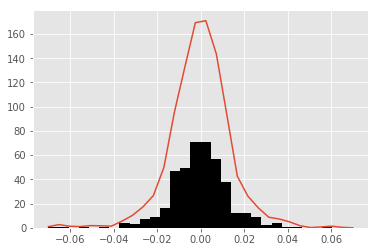

In [84]:
plot.hist(x=tag_weights,bins=30,range=(-0.07,0.07),color='black')
plotDensityCurve(tag_weights,(-0.07,0.07,30),0.25,5,data=None)

We see that the distribution of tag weights follows a binomial distribution. Which tags are most strongly correlated with high ratings per view?

In [92]:
inverted_tags = dict([v,k] for k,v in all_tags.items())
tag_columns = ('features',)
tag_df = pd.DataFrame({'features': tag_weights})
best_tags = tag_df.sort_values('features',ascending=False).head(10).index.tolist()
for tag in best_tags:
    print(inverted_tags[tag]) if tag in inverted_tags else ""

meme
blockchain
ecology
algorithm
TED en Español
introvert
china
capitalism
prediction
origami


These are the most inversely correlated: 

In [93]:
worst_tags = tag_df.sort_values('features',ascending=True).head(10).index.tolist()
for tag in worst_tags:
    print(inverted_tags[tag]) if tag in inverted_tags else ""

discovery
biomechanics
farming
identity
driverless cars
india
mindfulness
neuroscience


It's quite possible this analysis suffers from small sample size. Some tags might have very few talks, skewing the ratings per view excessively. The following code is credited to Rounak Banik for finding the most popular tags:

In [94]:
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'
theme_df = df.drop('tags', axis=1).join(s)
theme_df.head()
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
top_themes = pop_themes.head(20)
top_themes

,theme,talks
0,technology,727
1,science,567
2,global issues,501
3,culture,486
4,TEDx,450
5,design,418
6,business,348
7,entertainment,299
8,health,236
9,innovation,229


The most popular themes for talks, sorted by rating per view coefficient:

In [97]:
top_theme_list = []
for theme in top_themes['theme'].tolist():
    top_theme_list.append((theme,tag_df['features'].tolist()[all_tags[theme]]))
sorted_list = sorted(top_theme_list,key=lambda x: -x[1])
theme_list = []
weight_list = []
for pair in sorted_list:
    theme_list.append(pair[0])
    weight_list.append(pair[1])

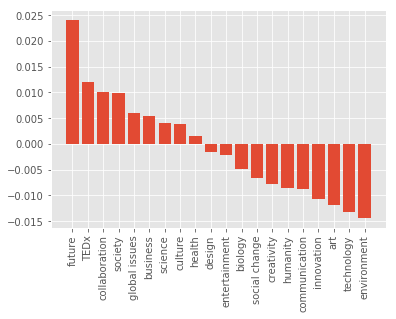

In [98]:
fig,ax = plot.subplots()
index = np.arange(0,20)
ax.bar(index,weight_list)
ax.set_xticklabels(theme_list)
plot.xticks(index)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plot.show()

We see that future, TEDx, collaboration, and society tend to generate the highest ratings per view, while categories such as environment, technology, art, and innovation have negative coefficients.

## Summary ##

In this analysis a unified, quantitative measure of rating (aggregate rating per view) was extracted from the data set. Two neural networks were trained on various features, including talk sentiment and themes, to predict this measure, achieving good accuracy. The relationship between ratings and these features was determined through examining the weights of the single-layer neural network.